In [1]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import Tensor
import torch
from torch.optim import Adam, SGD, Adamax
from sklearn.preprocessing import MinMaxScaler

# Models
First let's define our models, and the baseline model (ModelReLU). The latter will be used to compare our model in the defined task.

In [34]:
from localized_look.model import LoLoLayer

class ModelLoLo(nn.Module):
    def __init__(self, activation="invsquare"):
        super().__init__()
        self.layer = nn.Sequential(
            LoLoLayer(n_kernels=400, n_channels=2, fusion="channels", activation=activation),
            nn.LeakyReLU(.05),
            nn.Linear(400, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layer(x)

class ModelReLU(nn.Module):
    
    def __init__(self):
        super().__init__()
        n = 64
        self.layer = nn.Sequential(
            nn.Linear(2, n//2),
            nn.LeakyReLU(.05),
            nn.Linear(n//2, n),
            nn.LeakyReLU(.05),
            nn.Linear(n, n//2),
            nn.LeakyReLU(.05),
            nn.Linear(n//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer(x)

In [35]:
model_lolo = ModelLoLo()
model_relu = ModelReLU()

In [36]:
model_lolo

ModelLoLo(
  (layer): Sequential(
    (0): LoLoLayer(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=400, bias=True)
          (1): LoLoInvSquare()
        )
        (1): Sequential(
          (0): Linear(in_features=1, out_features=400, bias=True)
          (1): LoLoInvSquare()
        )
      )
      (fusion_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (2): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (3): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (4): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (5): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (6): Sequ

In [37]:
for param in list(model_lolo.layer.children())[0].parameters():
    print(param)

Parameter containing:
tensor([[-0.9161],
        [-0.8903],
        [ 0.2463],
        [ 0.1913],
        [ 0.0793],
        [-0.5012],
        [-0.7049],
        [ 0.8398],
        [-0.5109],
        [ 0.6700],
        [-0.1638],
        [-0.3639],
        [ 0.1454],
        [ 0.4667],
        [ 0.8944],
        [ 0.1507],
        [-0.8455],
        [ 0.2130],
        [-0.3269],
        [-0.9445],
        [-0.7128],
        [-0.5726],
        [-0.6683],
        [ 0.9395],
        [ 0.8191],
        [ 0.6723],
        [-0.5475],
        [ 0.8910],
        [-0.3199],
        [ 0.5959],
        [ 0.9758],
        [-0.0803],
        [-0.5139],
        [ 0.5452],
        [ 0.2811],
        [-0.3975],
        [ 0.5989],
        [-0.6174],
        [ 0.9894],
        [-0.1300],
        [-0.3952],
        [-0.5159],
        [-0.7053],
        [-0.1575],
        [-0.0253],
        [-0.8481],
        [-0.5720],
        [-0.9952],
        [-0.8683],
        [-0.1774],
        [ 0.9778],
        [

tensor([[ 0.2460, -0.2362]], requires_grad=True)
Parameter containing:
tensor([-0.4447], requires_grad=True)
Parameter containing:
tensor([[0.6576, 0.3565]], requires_grad=True)
Parameter containing:
tensor([0.6905], requires_grad=True)
Parameter containing:
tensor([[0.5125, 0.4260]], requires_grad=True)
Parameter containing:
tensor([0.6665], requires_grad=True)
Parameter containing:
tensor([[-0.6567, -0.1057]], requires_grad=True)
Parameter containing:
tensor([0.4123], requires_grad=True)
Parameter containing:
tensor([[ 0.0789, -0.2364]], requires_grad=True)
Parameter containing:
tensor([0.6842], requires_grad=True)
Parameter containing:
tensor([[-0.0054,  0.6150]], requires_grad=True)
Parameter containing:
tensor([0.6886], requires_grad=True)
Parameter containing:
tensor([[0.3029, 0.0670]], requires_grad=True)
Parameter containing:
tensor([-0.6736], requires_grad=True)
Parameter containing:
tensor([[0.4249, 0.2031]], requires_grad=True)
Parameter containing:
tensor([0.2671], requires

Parameter containing:
tensor([[ 0.2339, -0.2438]], requires_grad=True)
Parameter containing:
tensor([0.4482], requires_grad=True)
Parameter containing:
tensor([[0.0095, 0.6487]], requires_grad=True)
Parameter containing:
tensor([-0.6783], requires_grad=True)
Parameter containing:
tensor([[ 0.3197, -0.6210]], requires_grad=True)
Parameter containing:
tensor([0.4343], requires_grad=True)
Parameter containing:
tensor([[-0.3821, -0.0324]], requires_grad=True)
Parameter containing:
tensor([-0.4088], requires_grad=True)
Parameter containing:
tensor([[0.1552, 0.5813]], requires_grad=True)
Parameter containing:
tensor([-0.6892], requires_grad=True)
Parameter containing:
tensor([[0.5296, 0.4272]], requires_grad=True)
Parameter containing:
tensor([0.3385], requires_grad=True)
Parameter containing:
tensor([[-0.6498,  0.0788]], requires_grad=True)
Parameter containing:
tensor([0.4067], requires_grad=True)
Parameter containing:
tensor([[ 0.1133, -0.1479]], requires_grad=True)
Parameter containing:


In [38]:
model_relu

ModelReLU(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

# Benchmark
Our dataset will be a "checkerboard" like, i.e., with sparse locals where the label is one. The net figure is a visualization of this. There is 2 features (X and Y).

In [51]:
from torch.utils.data import DataLoader, Dataset
from localized_look.utils import create_labels_checker


class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
#         self.w = w
        assert len(x) == len(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]#, self.w[i]


scaler = MinMaxScaler(feature_range=(-5, 5))
    
x = np.random.rand(100000, 2)*240-120
y = create_labels_checker(x, 10, size=5, stride=20, start=-100)
# y = ((x > -15) & (x < - 5)) | ((x > 5) & (x < 15)) 

w = (y * .9 + .05).flatten()

idx = np.random.choice(np.arange(len(x)), size=5000, p=w/w.sum() , replace=False)

x = x[idx]
y = y[idx]

print(y.mean())

x = scaler.fit_transform(x)

x_true, y_true = x.copy(), y.copy()

x, y = torch.Tensor(x), torch.Tensor(y)

trainloader = torch.utils.data.DataLoader(
    dataset(x, y),
    batch_size=200,
    shuffle=True,
    num_workers=0
)
_ = model_lolo(x), model_relu(x)

0.3998


Just checking that all models are comparable in the number of parameters (the ReLU model has 6 more parameters).

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("LoLo model n parameters:", count_parameters(model_lolo))
print("ReLU model n parameters:", count_parameters(model_relu))

LoLo model n parameters: 3201
ReLU model n parameters: 4321


This is our training data. We can see that the label (Z axis) is 1 in specific points of the dataset.

Text(0.5, 0, 'Label')

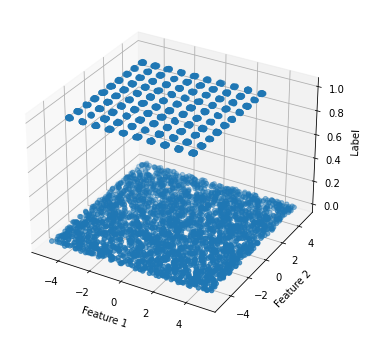

In [53]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], y)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111)

# ax.scatter(x[:, 0], y)

c:\users\paulo\anaconda3\envs\lolo\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


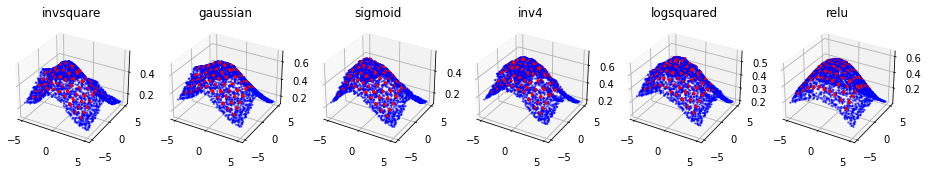

Epoch 0 :
invsquare loss:0.712, Mean batch time: 312.211ms
gaussian loss:0.689, Mean batch time: 323.294ms
sigmoid loss:0.659, Mean batch time: 355.333ms
inv4 loss:0.721, Mean batch time: 341.253ms
logsquared loss:0.694, Mean batch time: 359.925ms
relu loss:0.646, Mean batch time: 3.639ms


In [ ]:
from localized_look.utils import weight_init
import localized_look.activation as act
import time

activations = act.ACTIVATION_DICT

models = {act:ModelLoLo(activation=act) for act in activations}
models.update(
    {
        "relu": ModelReLU()
    }
)

for model in models.values():
    model.apply(weight_init)
    model.train()

optimizers = {model_key:Adam(models[model_key].parameters(), lr=5e-3) for model_key in models}
# optimizers = {model_key:SGD(models[model_key].parameters(), lr=1e-3) for model_key in models}
# optimizers = {model_key:Adamax(models[model_key].parameters(), lr=1e-2) for model_key in models}

loss_fn = nn.BCELoss()

times = {model_key:[] for model_key in models}
for epoch in range(200):
    losses = {model_key:[] for model_key in models}
    for x, y in trainloader:
        for optim in optimizers.values():
            optim.zero_grad()
        # ModelLoLo
        for model_key in models:
            start_time = time.time()
            pred = models[model_key].forward(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizers[model_key].step()
            losses[model_key] += [loss.item()]
            end_time = time.time()
            delta = end_time - start_time
            times[model_key] += [delta]
    # Calculate mean time using the last 5 epochs
    times[model_key] =  times[model_key][-len(trainloader)*5:]
    if epoch % 10 == 0:
        
        x, y = x_true, y_true

        fig = plt.figure(figsize=(16, 6))
        if x.shape[1] == 2:
            axes = [fig.add_subplot(100 + len(models)*10 + i + 1, projection='3d') for i in range(len(models))]
            for i, model_key in enumerate(models):
                pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
                axes[i].scatter(x[:, 0], x[:, 1], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
                axes[i].set_title(model_key)
            plt.show()
        if x.shape[1] == 1:
            axes = [fig.add_subplot(100 + len(models)*10 + i + 1) for i in range(len(models))]
            for i, model_key in enumerate(models):
                interm = list(list(models[model_key].layer.children())[0].layers.children())[0]
                pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
                axes[i].scatter(x[:, 0], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
                a, b = x_true.flatten(), interm.forward(torch.Tensor(x_true)).detach().numpy()
                for j in range(b.shape[1]):
                    axes[i].scatter(a, b[:, j], alpha=.2, s=1., cmap="bwr")
                axes[i].set_title(model_key)
            plt.show()
        
        print("Epoch", epoch, ":")
        for model_key in models:
            print(
                "{} loss:{:.3f}, Mean batch time: {:.3f}ms".format(
                    model_key,
                    np.mean(losses[model_key]),
                    np.mean(times[model_key])*1000,
                )
            )

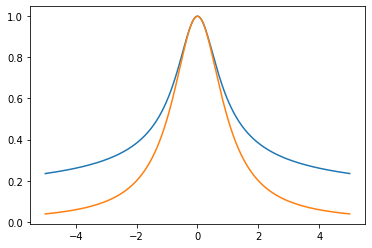

In [30]:
from localized_look import activation as act
x = np.linspace(-5, 5, 1000)
y = 1/(1 + np.log(x**2 + 1))
y_ = 1/(x**2 + 1)
plt.plot(x, y)
plt.plot(x, y_)
torch.log

In [ ]:
# x_ = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_ = np.concatenate([np.linspace(-2, 2, 100).reshape(-1, 1), np.linspace(-2, 2, 100).reshape(-1, 1)], axis=1)
x = torch.Tensor(x_)
m = list(model.layer.children())[0]
pred = m(x).detach()
# plt.plot(x_, pred)
# plt.show()
plt.plot(x_, model.forward(torch.Tensor(x_)).detach())
# plt.show()
# plt.plot(x_true, y_true)


In [ ]:
x= np.linspace(-3, 3, 1000)
mu, std = 0, 1
y1 = (1/(np.pi*(2*std)**.5))*np.exp(-.5*(x-mu)**2/std)
y2 = 1/(x**2 + 1)/5
plt.plot(x, y1)
plt.plot(x, y2)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# x = np.random.rand(1000, 2)
# a, b = x.T
# y = ((a < .4) & ( a > .1) &  (b < .9) & ( b > .5)) | ((a > .7) & ( a < .9) &  (b > .1) & ( b < .6))
x, y = x_true, y_true
pred = model.forward(torch.Tensor(x)).detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x[:, 0], x[:, 1], y, c=(pred>.5).astype(int).flatten())
ax.scatter(x[:, 0], x[:, 1], pred, c=y)
# ax.scatter(x[:, 0], x[:, 1], (pred>.2).astype(int).flatten(), c=y)


In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)*(1.2-sigmoid(x))
plt.plot(x, y)